# Uploading Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving energy_efficiency_data.csv to energy_efficiency_data.csv


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


# Import Libraries


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import joblib

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-darkgrid')

# Read Data

In [4]:
data = pd.read_csv('energy_efficiency_data.csv')
data

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.980,514.500,294.000,110.250,7.000,2,0.000,0,15.550,21.330
1,0.980,514.500,294.000,110.250,7.000,3,0.000,0,15.550,21.330
2,0.980,514.500,294.000,110.250,7.000,4,0.000,0,15.550,21.330
3,0.980,514.500,294.000,110.250,7.000,5,0.000,0,15.550,21.330
4,0.900,563.500,318.500,122.500,7.000,2,0.000,0,20.840,28.280
...,...,...,...,...,...,...,...,...,...,...
763,0.640,784.000,343.000,220.500,3.500,5,0.400,5,17.880,21.400
764,0.620,808.500,367.500,220.500,3.500,2,0.400,5,16.540,16.880
765,0.620,808.500,367.500,220.500,3.500,3,0.400,5,16.440,17.110
766,0.620,808.500,367.500,220.500,3.500,4,0.400,5,16.480,16.610


# EDA


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


there is no missing values

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.000,0.764,0.106,0.620,0.682,0.750,0.830,0.980
Surface_Area,768.000,671.708,88.086,514.500,606.375,673.750,741.125,808.500
Wall_Area,768.000,318.500,43.626,245.000,294.000,318.500,343.000,416.500
Roof_Area,768.000,176.604,45.166,110.250,140.875,183.750,220.500,220.500
Overall_Height,768.000,5.250,1.751,3.500,3.500,5.250,7.000,7.000
Orientation,768.000,3.500,1.119,2.000,2.750,3.500,4.250,5.000
Glazing_Area,768.000,0.234,0.133,0.000,0.100,0.250,0.400,0.400
Glazing_Area_Distribution,768.000,2.812,1.551,0.000,1.750,3.000,4.000,5.000
Heating_Load,768.000,22.307,10.090,6.010,12.992,18.950,31.668,43.100
Cooling_Load,768.000,24.588,9.513,10.900,15.620,22.080,33.133,48.030


In [7]:
data.duplicated().sum()

np.int64(0)

there is no duplicated values

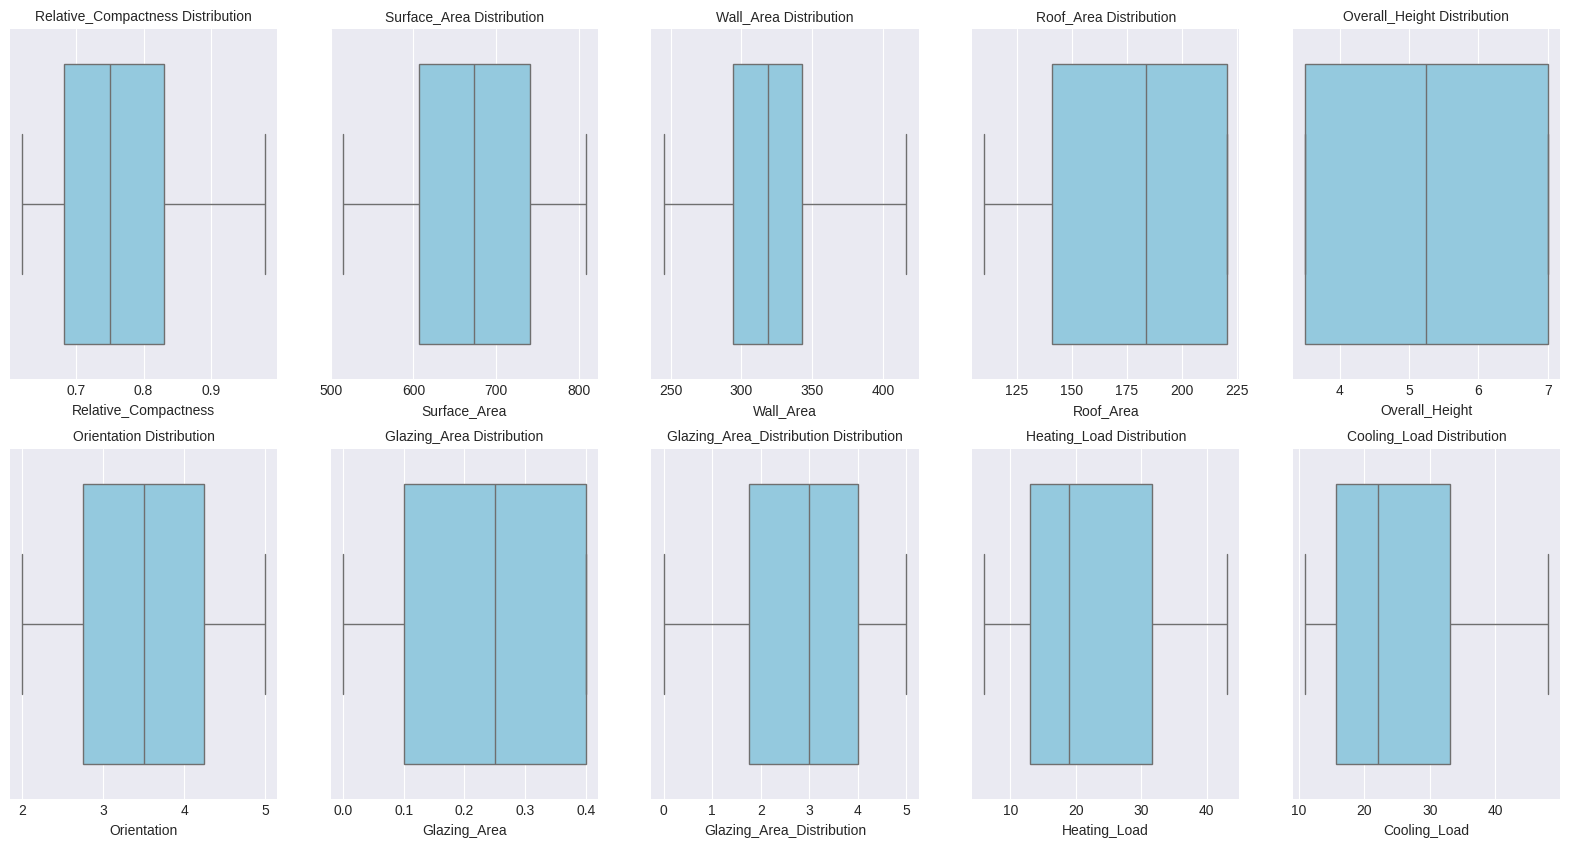

In [8]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(data.columns, start= 1):
    plt.subplot(2, 5, i)
    sns.boxplot(data= data, x=col, color='skyblue')
    plt.title(f"{col} Distribution", fontsize=10)

plt.show()

In [9]:
for col in data.columns:
    if data[col].dtype != 'object':
        mean = data[col].mean()
        std = data[col].std()
        upper = mean + 3*std
        lower = mean - 3*std

        outliers = data[(data[col] > upper) | (data[col] < lower)]
        print(f"{col}: {len(outliers)} outliers")


Relative_Compactness: 0 outliers
Surface_Area: 0 outliers
Wall_Area: 0 outliers
Roof_Area: 0 outliers
Overall_Height: 0 outliers
Orientation: 0 outliers
Glazing_Area: 0 outliers
Glazing_Area_Distribution: 0 outliers
Heating_Load: 0 outliers
Cooling_Load: 0 outliers


there is no any outliers

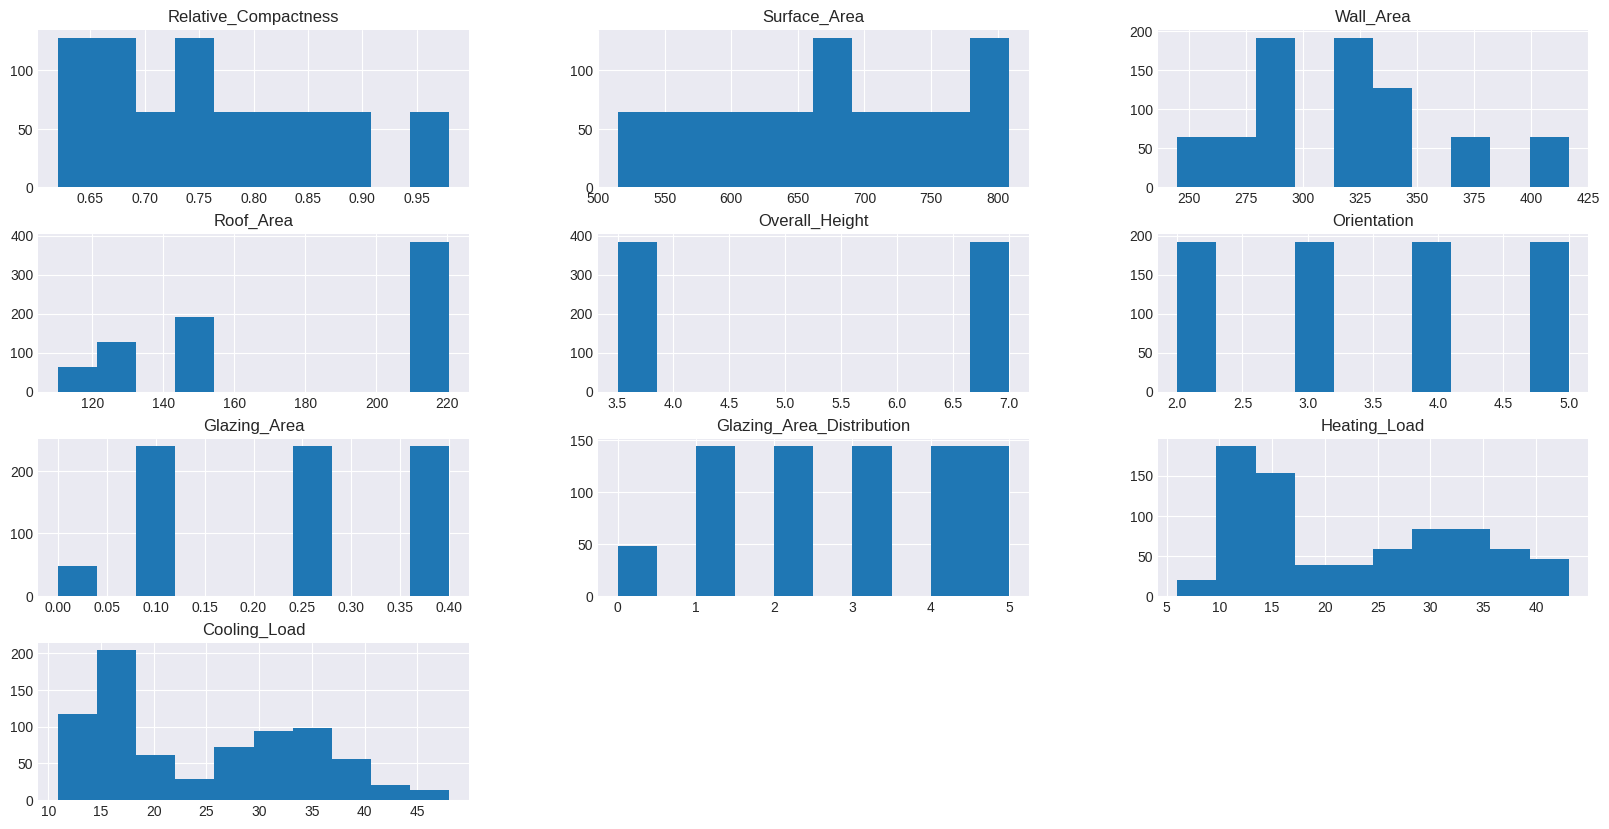

In [10]:
data.hist(figsize=(20,10))
plt.show()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


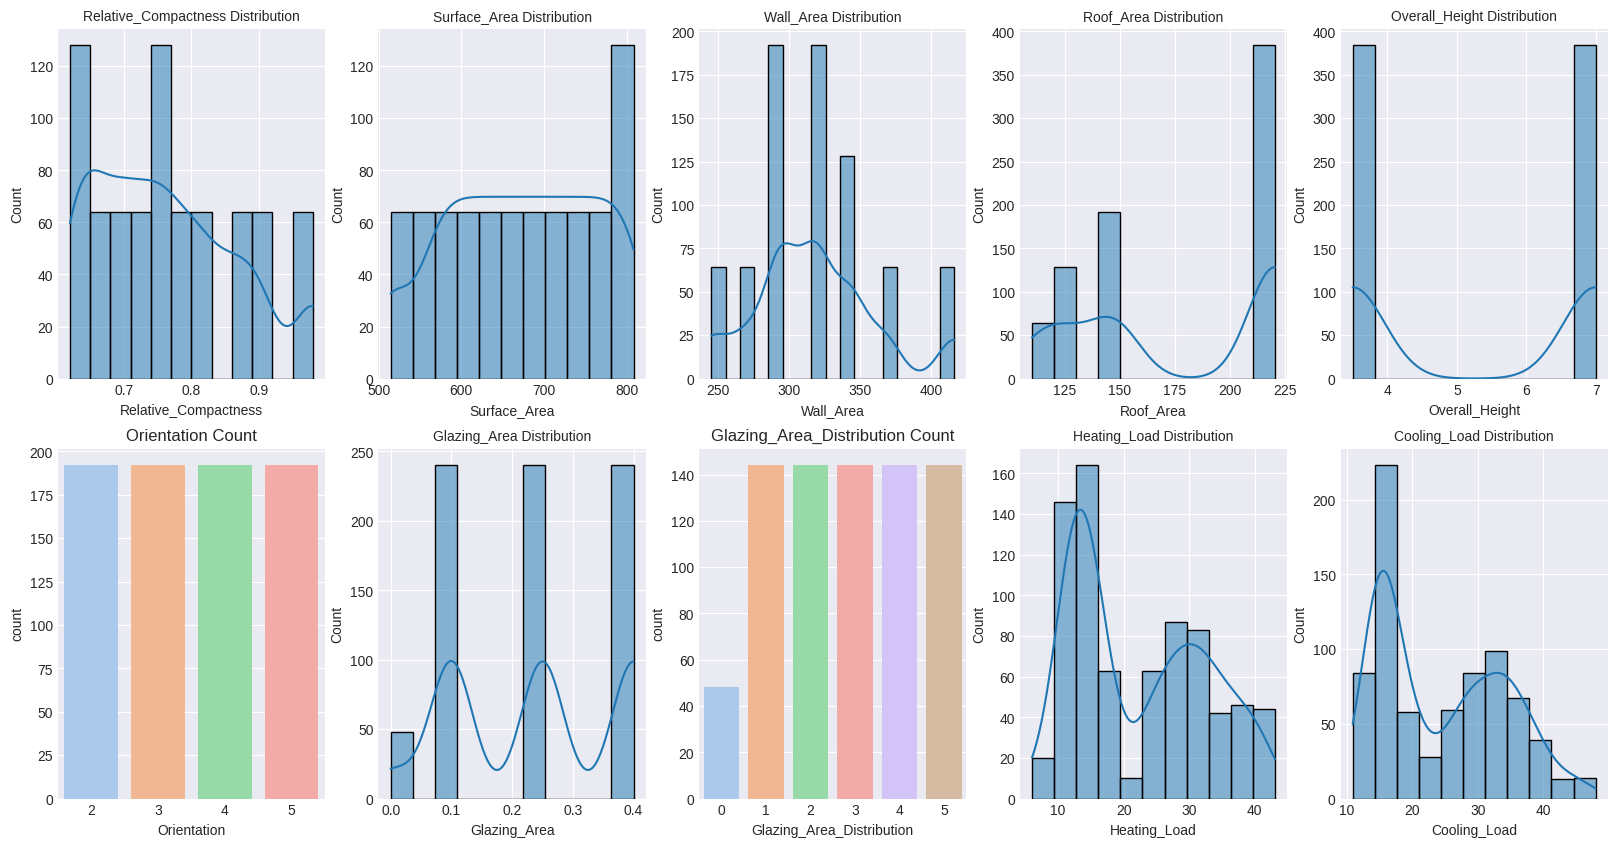

In [12]:


cat = ['Orientation', 'Glazing_Area_Distribution']
plt.figure(figsize=(20, 10))
for i, col in enumerate(data.columns, start=1):
    if col not in cat:
      plt.subplot(2, 5, i)
      sns.histplot(data[col], kde=True)
      plt.title(f'{col} Distribution', fontsize=10)
    else:
      plt.subplot(2, 5, i)
      sns.countplot(x=col, data=data, palette='pastel')
      plt.title(f'{col} Count')

plt.show()


In [13]:
for i in data.columns:
  print(i)

Relative_Compactness
Surface_Area
Wall_Area
Roof_Area
Overall_Height
Orientation
Glazing_Area
Glazing_Area_Distribution
Heating_Load
Cooling_Load


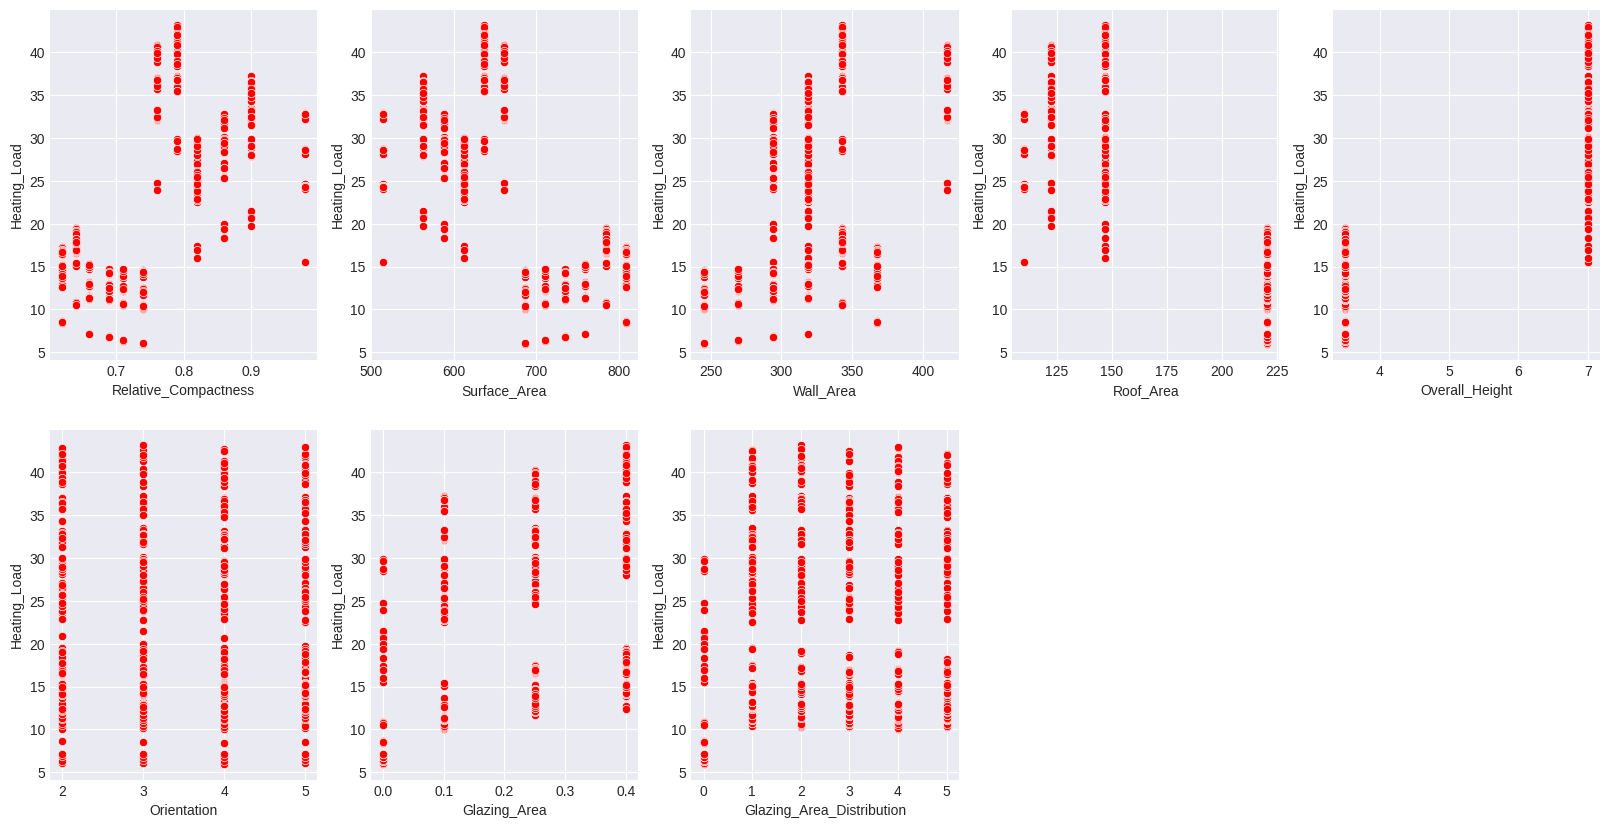

In [14]:
features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']
plt.figure(figsize=(20, 10))
for i, col in enumerate(features, start= 1):
  plt.subplot(2, 5, i)
  sns.scatterplot(x= col, y='Heating_Load', data=data, color= 'red')

plt.show()

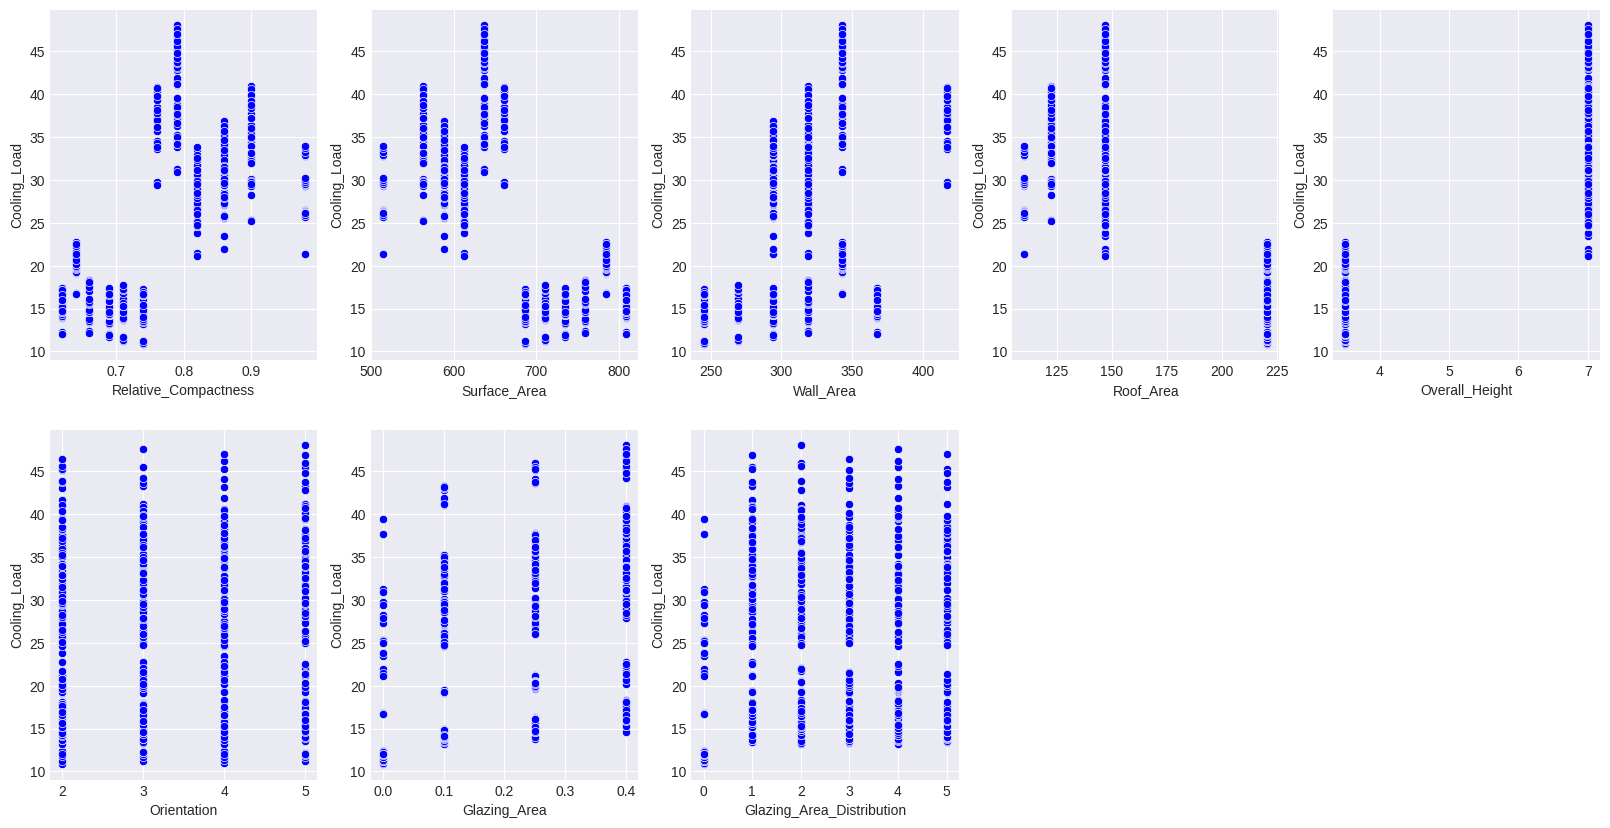

In [15]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(features, start= 1):
  plt.subplot(2, 5, i)
  sns.scatterplot(x= col, y='Cooling_Load', data=data, color= 'blue')

plt.show()

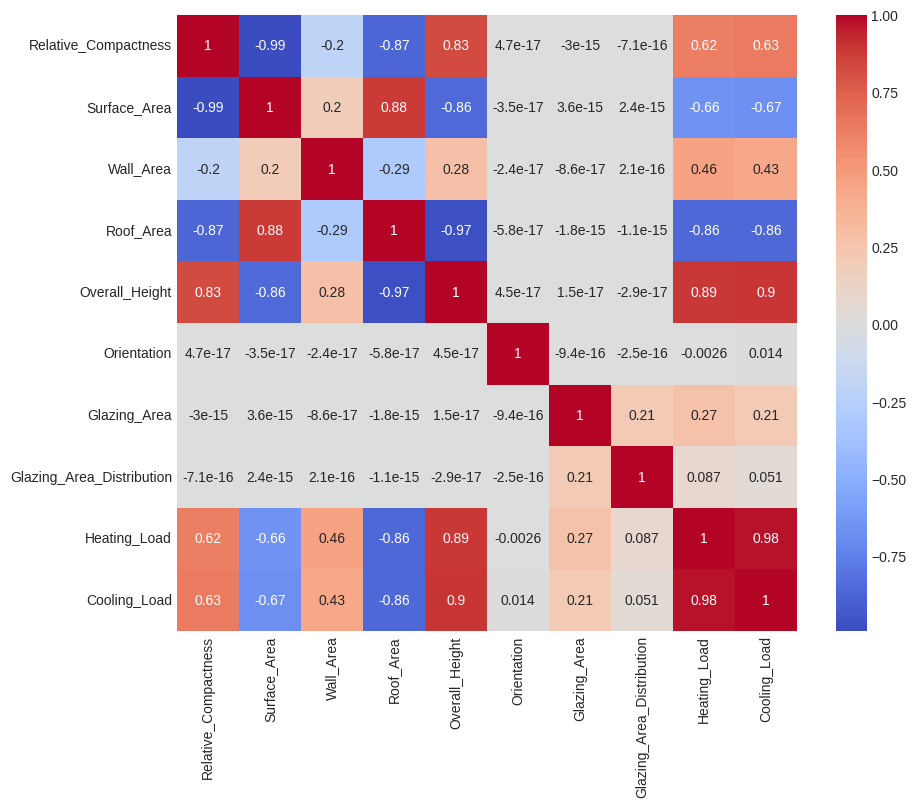

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

there is a very big positive correlation between Cooling_Load and Heating_Load

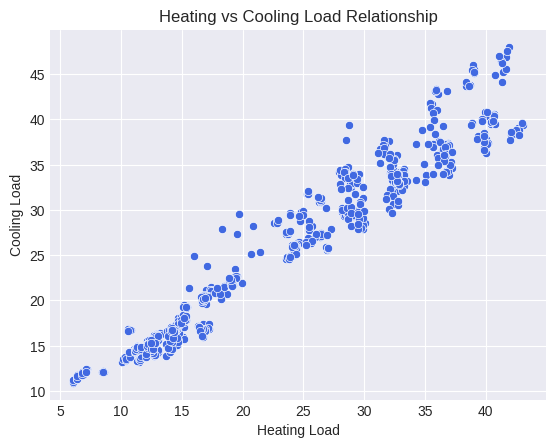

In [17]:

sns.scatterplot(x='Heating_Load', y='Cooling_Load', data=data, color='royalblue')
plt.title('Heating vs Cooling Load Relationship')
plt.xlabel('Heating Load')
plt.ylabel('Cooling Load')
plt.show()

So, We can create a new feature(overall energy efficiency) and drop the other two(Cooling_Load, Heating_Load).

In [18]:
data['Avg_Load'] = (data['Heating_Load'] + data['Cooling_Load']) / 2

In [19]:
data

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load,Avg_Load
0,0.980,514.500,294.000,110.250,7.000,2,0.000,0,15.550,21.330,18.440
1,0.980,514.500,294.000,110.250,7.000,3,0.000,0,15.550,21.330,18.440
2,0.980,514.500,294.000,110.250,7.000,4,0.000,0,15.550,21.330,18.440
3,0.980,514.500,294.000,110.250,7.000,5,0.000,0,15.550,21.330,18.440
4,0.900,563.500,318.500,122.500,7.000,2,0.000,0,20.840,28.280,24.560
...,...,...,...,...,...,...,...,...,...,...,...
763,0.640,784.000,343.000,220.500,3.500,5,0.400,5,17.880,21.400,19.640
764,0.620,808.500,367.500,220.500,3.500,2,0.400,5,16.540,16.880,16.710
765,0.620,808.500,367.500,220.500,3.500,3,0.400,5,16.440,17.110,16.775
766,0.620,808.500,367.500,220.500,3.500,4,0.400,5,16.480,16.610,16.545


In [20]:
data.drop(['Heating_Load', 'Cooling_Load'], inplace= True, axis= 1)

In [21]:
data

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Avg_Load
0,0.980,514.500,294.000,110.250,7.000,2,0.000,0,18.440
1,0.980,514.500,294.000,110.250,7.000,3,0.000,0,18.440
2,0.980,514.500,294.000,110.250,7.000,4,0.000,0,18.440
3,0.980,514.500,294.000,110.250,7.000,5,0.000,0,18.440
4,0.900,563.500,318.500,122.500,7.000,2,0.000,0,24.560
...,...,...,...,...,...,...,...,...,...
763,0.640,784.000,343.000,220.500,3.500,5,0.400,5,19.640
764,0.620,808.500,367.500,220.500,3.500,2,0.400,5,16.710
765,0.620,808.500,367.500,220.500,3.500,3,0.400,5,16.775
766,0.620,808.500,367.500,220.500,3.500,4,0.400,5,16.545


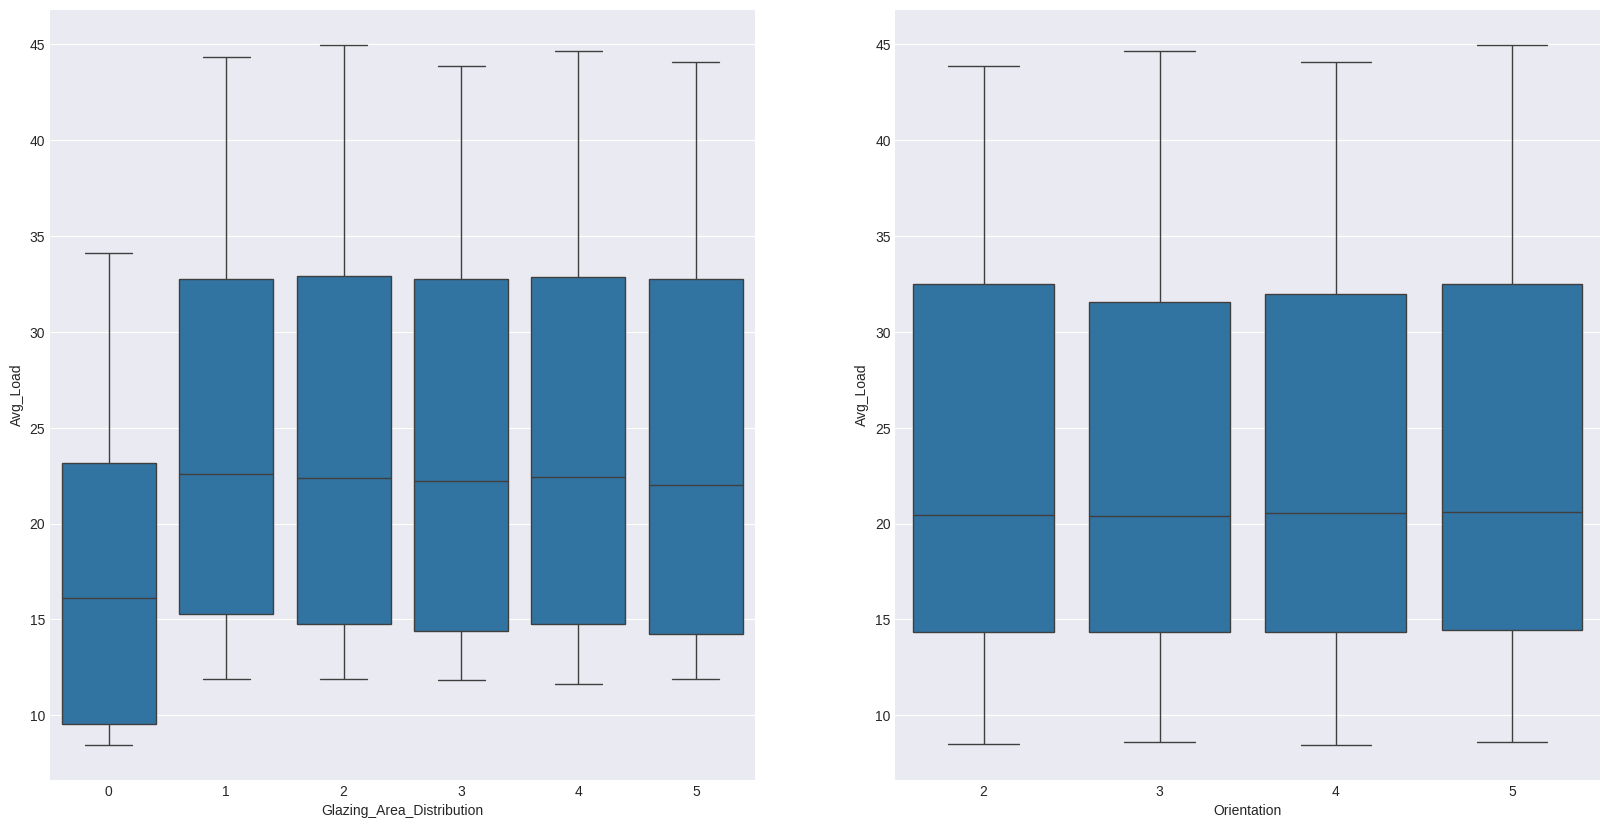

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.boxplot(x= 'Glazing_Area_Distribution', y= 'Avg_Load', data= data)
plt.subplot(1, 2, 2)
sns.boxplot(x= 'Orientation', y= 'Avg_Load', data= data)
plt.show()

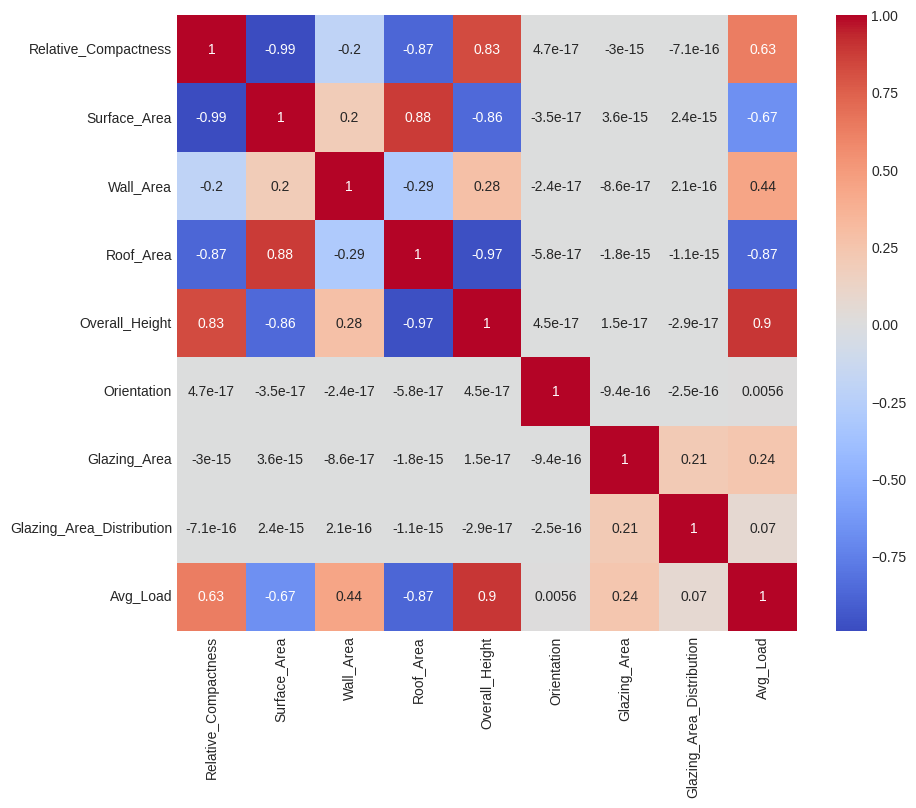

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [24]:
for i in data.columns:
  print(i)

Relative_Compactness
Surface_Area
Wall_Area
Roof_Area
Overall_Height
Orientation
Glazing_Area
Glazing_Area_Distribution
Avg_Load


Effect of features at the target(Avg_Load):


1.   High: Overall_Height (positive correlation), Roof_Area (negative correlation)
2.   Medium: Relative_Compactness (positive correlation), Surface_Area (negative correlation), Wall_Area (positive correlation)
3.   Low: Orientation (positive correlation) , Glazing_Area (positive correlation), Glazing_Area_Distribution (positive correlation)







In [25]:
data['Orientation'].unique()

array([2, 3, 4, 5])

In [26]:
data['Glazing_Area_Distribution'].unique()

array([0, 1, 2, 3, 4, 5])

# Data Preprocessing

In [27]:
data

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Avg_Load
0,0.980,514.500,294.000,110.250,7.000,2,0.000,0,18.440
1,0.980,514.500,294.000,110.250,7.000,3,0.000,0,18.440
2,0.980,514.500,294.000,110.250,7.000,4,0.000,0,18.440
3,0.980,514.500,294.000,110.250,7.000,5,0.000,0,18.440
4,0.900,563.500,318.500,122.500,7.000,2,0.000,0,24.560
...,...,...,...,...,...,...,...,...,...
763,0.640,784.000,343.000,220.500,3.500,5,0.400,5,19.640
764,0.620,808.500,367.500,220.500,3.500,2,0.400,5,16.710
765,0.620,808.500,367.500,220.500,3.500,3,0.400,5,16.775
766,0.620,808.500,367.500,220.500,3.500,4,0.400,5,16.545


In [28]:
cat_features = ['Orientation', 'Glazing_Area_Distribution']
num_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area',
                'Roof_Area', 'Overall_Height', 'Glazing_Area']

X = data.drop(['Avg_Load'], axis=1, errors='ignore')
y = data['Avg_Load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


In [29]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

# Build Model

models that i will use in this project

In [30]:
models = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'Bagging': BaggingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGB': XGBRegressor(verbosity=0),
    'LGBM': LGBMRegressor(verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

Baseline Evaluation

In [31]:
baseline_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    baseline_results[name] = np.mean(scores)
    print(f"{name:20s} → R² = {np.mean(scores):.3f}")

LinearRegression     → R² = 0.911
SVR                  → R² = 0.922
DecisionTree         → R² = 0.987
RandomForest         → R² = 0.991
Bagging              → R² = 0.990
ExtraTrees           → R² = 0.988
GradientBoosting     → R² = 0.994
AdaBoost             → R² = 0.956
XGB                  → R² = 0.996
LGBM                 → R² = 0.994
CatBoost             → R² = 0.997


In [32]:
results = {
    'Model': [
        'LinearRegression',
        'SVR',
        'DecisionTree',
        'RandomForest',
        'Bagging',
        'ExtraTrees',
        'GradientBoosting',
        'AdaBoost',
        'XGB',
        'LGBM',
        'CatBoost'
    ],
    'R2_Score': [
        0.911,
        0.922,
        0.987,
        0.991,
        0.991,
        0.988,
        0.994,
        0.955,
        0.996,
        0.994,
        0.997
    ]
}

df_results = pd.DataFrame(results)

df_results = df_results.sort_values(by='R2_Score', ascending=False).reset_index(drop=True)

df_results


,Model,R2_Score
0,CatBoost,0.997
1,XGB,0.996
2,GradientBoosting,0.994
3,LGBM,0.994
4,RandomForest,0.991
5,Bagging,0.991
6,ExtraTrees,0.988
7,DecisionTree,0.987
8,AdaBoost,0.955
9,SVR,0.922


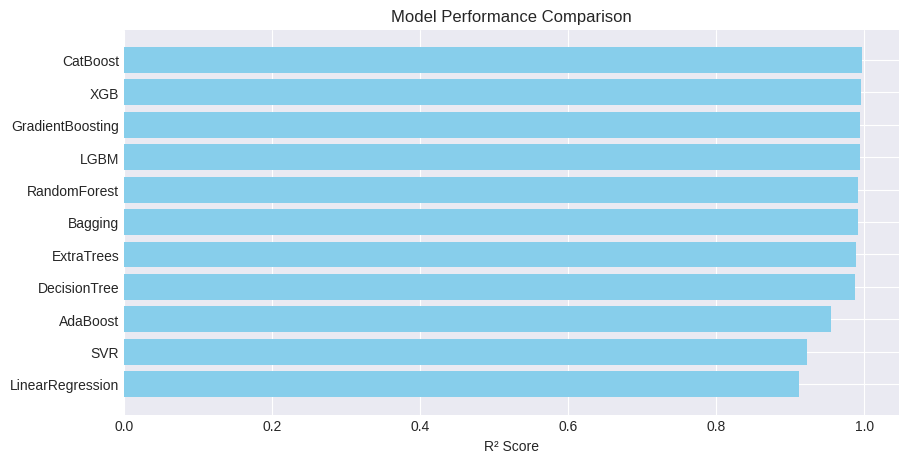

In [33]:
plt.figure(figsize=(10,5))
plt.barh(df_results['Model'], df_results['R2_Score'], color='skyblue')
plt.xlabel('R² Score')
plt.title('Model Performance Comparison')
plt.gca().invert_yaxis()
plt.show()

We will take the first four models to make grid search at it:


1.   CatBoost
2.   XGB
3.   GradientBoosting
4.   LGBM

# Grid Search

parameter that i will use it in the Grid Search

In [34]:
param_grids = {

    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },

    'XGB': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1],
        'model__colsample_bytree': [0.8, 1]
    },

    'LGBM': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [31, 63],
        'model__max_depth': [-1, 5, 10]
    },

    'CatBoost': {
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.03, 0.1],
        'model__iterations': [200, 400]
    }

}


In [35]:
best_models = {}

for name in ['CatBoost', 'XGB', 'GradientBoosting', 'LGBM']:
    print(f"Running GridSearchCV for {name}...")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', models[name])
    ])

    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    print(f"Best R² = {grid.best_score_:.3f}")
    print("Best Parameters:", grid.best_params_)


Running GridSearchCV for CatBoost...
Best R² = 0.997
Best Parameters: {'model__depth': 6, 'model__iterations': 400, 'model__learning_rate': 0.1}
Running GridSearchCV for XGB...
Best R² = 0.997
Best Parameters: {'model__colsample_bytree': 1, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
Running GridSearchCV for GradientBoosting...
Best R² = 0.997
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Running GridSearchCV for LGBM...
Best R² = 0.996
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__num_leaves': 31}


it's clear that the all models is very efficient at the training phase, but we need to test this models at the testing data(The model has never seen this data before) to see what is the lowest overfitted model.

In [36]:
print(best_models)

{'CatBoost': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Relative_Compactness',
                                                   'Surface_Area', 'Wall_Area',
                                                   'Roof_Area',
                                                   'Overall_Height',
                                                   'Glazing_Area']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Orientation',
                                                   'Glazing_Area_Distribution'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7e73f9337ad0>)]), 'XGB': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
              

In [37]:
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, rmse, mae))

df_test_results = pd.DataFrame(results, columns=["Model", "Test R²", "RMSE", "MAE"])
df_test_results = df_test_results.sort_values(by="Test R²", ascending=False).reset_index(drop=True)

df_test_results


,Model,Test R²,RMSE,MAE
0,CatBoost,0.998,0.468,0.300
1,GradientBoosting,0.997,0.505,0.319
2,XGB,0.997,0.550,0.321
3,LGBM,0.996,0.631,0.417


its clear that the CatBoost is the best in the training and testing phases

Now, we will build a neural network to compare with the CatBoost model.

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Define the Neural Network Builder

In [39]:
def build_nn(input_dim, hidden1=128, hidden2=64, learning_rate=0.001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(hidden1, input_dim=input_dim, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # output layer (regression)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

Train the Model (No Dropout First)

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

nn_model = build_nn(input_dim=X_train_scaled.shape[1], dropout_rate=0.0)

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 661.1774 - val_loss: 508.6754
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 542.1821 - val_loss: 392.9995
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 392.2436 - val_loss: 238.5312
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 217.0508 - val_loss: 96.2124
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98.6625 - val_loss: 48.1629
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.6926 - val_loss: 42.1043
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 29.3635 - val_loss: 32.2420
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27.2993 - val_loss: 28.2745
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.8933 - val_loss: 26.9279
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.1181 - val_loss: 25.5086
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.8004 - val_loss: 24.4438
Epoch 12/500
16/16 ━━━━━━━━━━━

Evaluate the model

In [41]:
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)

df_nn_result = pd.DataFrame([['Neural Network', r2_nn, rmse_nn, mae_nn]],
                            columns=['Model', 'Test R²', 'RMSE', 'MAE'])

df_nn_result

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


,Model,Test R²,RMSE,MAE
0,Neural Network,0.995,0.696,0.524


Plot Training History

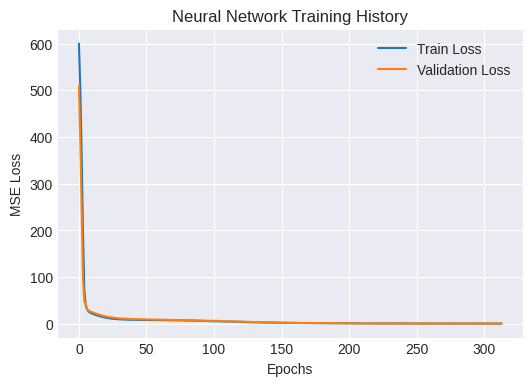

In [42]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

its clear that the 50 epochs is the best choice by elbow method

let's try adding Dropout

In [43]:
nn_model_dropout = build_nn(input_dim=X_train_scaled.shape[1],
                            dropout_rate=0.2)

history_dropout = nn_model_dropout.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 597.3418 - val_loss: 518.3648
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 506.5388 - val_loss: 415.4346
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 453.3816 - val_loss: 269.8072
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 255.2068 - val_loss: 121.4811
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 114.6161 - val_loss: 44.2690
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.4161 - val_loss: 36.0254
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.4362 - val_loss: 30.2128
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.5490 - val_loss: 28.0490
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.3362 - val_loss: 26.9985
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.9861 - val_loss: 25.7826
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.0675 - val_loss: 24.9138
Epoch 12/500
16/16 ━━━━━━━━━━━

Evaluate the model

In [44]:
y_pred_nn = nn_model_dropout.predict(X_test_scaled).flatten()

r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)

df_nn_result = pd.DataFrame([['Neural Network', r2_nn, rmse_nn, mae_nn]],
                            columns=['Model', 'Test R²', 'RMSE', 'MAE'])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [45]:
df_nn_result

,Model,Test R²,RMSE,MAE
0,Neural Network,0.919,2.798,1.982


This is expected from the neural network because the data is small

its clear that, the CatBoost model is very high predictive power

# Save the model(CatBoost)

In [46]:
joblib.dump(best_models['CatBoost'], 'best_catboost_model.joblib')

['best_catboost_model.joblib']